In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import Rbf
from scipy import integrate
from scipy.interpolate import interp1d
import io
import nbinteract as nbi
from ipywidgets import interact
import scipy.ndimage as ndimage

In [2]:
x_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/x.txt',header=None)[0]
xfit = np.array(x_saved.values) #cm

t_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/time.txt',header=None)[0]
timeFit = np.array(t_saved.values) #ms

ne_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/ne.txt',header=None)[0]
ne_fit = np.reshape(np.array(ne_saved),(len(timeFit),len(xfit))) #1/cc

Te_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/Te.txt',header=None)[0]
Te_fit = np.reshape(np.array(Te_saved),(len(timeFit),len(xfit))) #eV

Vp_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/Vp.txt',header=None)[0]
Vp_fit = np.reshape(np.array(Vp_saved),(len(timeFit),len(xfit))) #V

GrRate_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/GroundRate.txt',header=None)[0]
Rate_fit = GrRate_saved #cm^3/s

Tgrid_saved = pd.read_csv('C:/Users/kjerr/Documents/Plasma Research/LAPD He-H Plasma/Python Scripts/ProcessedData/11_4_20/T.txt',header=None)[0]
T_grid = Tgrid_saved #eV

0.08504503475046216 6.54008334849657


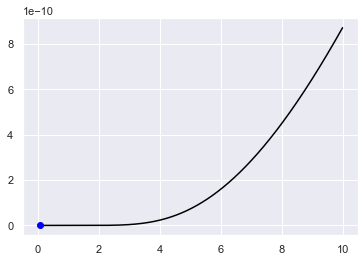

In [3]:
f_rate = interp1d(T_grid,Rate_fit)
print(np.min(Te_fit),np.max(Te_fit))
plt.plot(T_grid,Rate_fit,color='black')
plt.plot(0.085,f_rate(0.085),marker='o',color='blue')

In [4]:
t, x = timeFit-timeFit[0], xfit
dx = np.abs(xfit[1]-xfit[0])/1.2
dt = np.abs(timeFit[1]-timeFit[0])/1.2

def xt_zw(x,t,v0):
    z = t/1000+x/v0
    w = t/1000-x/v0
    return z,w

def zw_xt(z,w,v0):
    t = (w+z)*1000/2
    x = (z-w)*np.abs(v0)/2
    return x,t

def S_p(z,w,v0):
    x,t_ = zw_xt(z,w,v0)
    timeBoo = np.logical_and(t_>t[0],t_<t[-1])
    if timeBoo and np.abs(x)<np.max(xfit):
        ix = np.isclose(x,xfit,atol=dx)
        it = np.isclose(t_,t,atol=dt)
        ne_dummy = ne_fit[it,ix]*1.9
        Te_dummy = Te_fit[it,ix]
        if len(ne_dummy)==1:
            return ne_dummy*f_rate(Te_dummy) #1/s
        elif len(ne_dummy)>1:
            return np.mean(ne_dummy*f_rate(Te_dummy)) #1/s
        else:
            print('np error')
            return np.nan
    else:
        return 0 #1/s
    
def S_beam(z,w,v0):
    dummy = 0
    x,t = zw_xt(z,w,v0)
    if np.abs(x)<40:
        dummy = S_LaB6(t)*(1-np.tanh((x-10)/0.5))/2 + S_BaO(t)*(1-np.tanh((x-28.5)/0.5))/2
        return dummy #1/s
    else:
        return 0 #1/s

def n0He_r(x,t,v0):
    z,w =xt_zw(x,t,v0)
    z_prime = np.linspace(-w,z,1000)
    Sb = np.zeros(len(z_prime))
    Sp = np.zeros(len(z_prime))
    i=0
    for z_p in z_prime:
        #Sb[i] = S_beam(z_p,w,v0)
        Sp[i] = S_p(z_p,w,v0)
        i =i+1
    ln_n0 = -np.trapz(Sp,z_prime)
    n0 = np.exp(ln_n0)
    return n0

In [5]:
v_th = 8e4 #cm/s
v_dist = np.linspace(v_th/2,v_th,2) #cm/s
n0He_r_arr = np.zeros((len(v_dist),len(t),len(x)))
n0He_l_arr = np.zeros((len(v_dist),len(t),len(x)))

import time
start_time = time.time()
for iv in range(len(v_dist)):
    for ixt in range(len(t)):
        for ix in range(len(x)):
            n0He_r_arr[iv,ixt,ix] = n0He_r(x[ix],t[ixt],v_dist[iv])
            n0He_l_arr[iv,ixt,99-ix] = n0He_r_arr[iv,ixt,ix]
finish_time = time.time()
dtime_code = finish_time-start_time
code_time = dtime_code*len(v_dist)*len(t)*len(x)
print(dtime_code)

130.21413731575012


In [6]:
nHe = 0.5713740222626758e12
def f(it,iv):
    fig, (ax1) = plt.subplots(figsize=(6, 4), ncols=1)
    ax1.plot(xfit,nHe*n0He_r_arr[iv,it,:]/2,color='blue',label='Right Traveling $He^0$')
    ax1.plot(xfit,nHe*n0He_l_arr[iv,it,:]/2,color='red',label='Left Traveling $He^0$')
    ax1.plot(xfit,(nHe*n0He_r_arr[iv,it,:]+nHe*n0He_l_arr[iv,it,:])/2,color='black',label='Total $He^0$, time={}'.format(timeFit[it]))
    ax1.set_ylabel('$n_0$[1/cc]')
    ax1.set_xlabel('x [cm]')
    ax1.legend()
    ax1.set_ylim([0,nHe*1.5])
    plt.show()
interact(f,it=(0,24),iv=(0,1));

interactive(children=(IntSlider(value=12, description='it', max=24), IntSlider(value=0, description='iv', max=…

In [7]:
nHe_test = (nHe*n0He_r_arr[1]+nHe*n0He_l_arr[1])/2

In [8]:
def emis_monochromator(ne,Te,n0,T_He):
    import sys
    sys.path.append('../')
    from colradpy import colradpy
    import numpy as np
    from scipy.special import gamma, factorial

    fil = 'mom97_ls#he0.dat' #adf04 file
    
    if Te<1.1:
        temperature_arr = np.repeat(1,2)
    else:
        temperature_arr = np.repeat(Te,2)
    metastable_levels = np.array([0])   #metastable level, just ground chosen here
    density_arr = np.repeat(ne,2)
    He = colradpy(fil,metastable_levels,temperature_arr,density_arr,use_recombination=True,
              use_recombination_three_body = True,use_ionization=True,suppliment_with_ecip=True)
    He.solve_cr()

    ############# PEC w/o opacity ###########

    pec_ind668 = np.where( (He.data['processed']['wave_air'] >666 ) &\
                    (He.data['processed']['wave_air'] <669 ))[0]
    PEC668 = 0
    for ispex in pec_ind668:
        PEC668 = He.data['processed']['pecs'][ispex,0,:,:].flatten()[0]+PEC668
        
    pec_ind706 = np.where( (He.data['processed']['wave_air'] >705 ) &\
                    (He.data['processed']['wave_air'] <707 ))[0]
    PEC706= 0
    for ispex in pec_ind706:
        PEC706 = He.data['processed']['pecs'][ispex,0,:,:].flatten()[0]+PEC706


    pec_ind728 = np.where( (He.data['processed']['wave_air'] >727 ) &\
                    (He.data['processed']['wave_air'] <729 ))[0]
    
    PEC728= 0
    for ispex in pec_ind728:
        PEC728 = He.data['processed']['pecs'][ispex,0,:,:].flatten()[0]+PEC728
    
    #R1 = PEC668/PEC728
    #R2 = PEC728/PEC706
    
    n_frac = np.zeros(len(He.data['atomic']['energy'][1:]))
    
    n_frac=He.data['processed']['pop_lvl'][0,:,0,0,0]/\
                      np.sum(He.data['processed']['pop_lvl'][0,:,0,0,0])
    
    n_levels = n0*n_frac #cc
    
    
     ############# Atomic Data for Helium 0+ #############
    
    gP1 = 3
    gP3 = 5
    gD1 = 5
    gS3 = 3
    gS1 = 1

    A668 = 6.3705e7 #1/s
    A706 = 1.5474e7 #1/s
    A728 = 1.8299e7 #1/s
    
     ############## Opacity Calculation ############

    # 3/2 kT = 1/2 m v^2
    # (3kT/m)^0.5 = v (thermal velocity)
    # T_i= 0.3 eV (Larson calculation)
    mHe = 6.6464764e-27 #kg
    # 1 eV = 1.60218e-19 J
    kT_J = T_He*1.60218e-19
    v = np.sqrt(3*kT_J/mHe)*100 #cm/s
    #plasma radius r= 7cm

    ########## 706 Tau ############
    l0 = 706e-7 #cm
    Tau706 = n_levels[2]*gS3/gP3*A706*l0**3/(8*np.pi**(3/2)*v) #1/cm

    ########## 728 Tau ############
    l0 = 728e-7 #cm
    Tau728 = n_levels[3]*gS1/gP1*A728*l0**3/(8*np.pi**(3/2)*v) #1/cm
    

    ########## 668 Tau ############
    l0 = 668e-7 #cm
    Tau668 = n_levels[3]*gD1/gP1*A668*l0**3/(8*np.pi**(3/2)*v) #1/cm
    
    
    emis668 = PEC668 #ph*cm^3/s
    emis706 = PEC706 #ph*cm^3/s
    emis728 = PEC728 #ph*cm^3/s
    coef668 = 1239.8/668*1.6e-19 #J/ph
    coef706 = 1239.8/706*1.6e-19 #J/ph
    coef728 = 1239.8/728*1.6e-19 #J/ph
    n_He_706_up = n_levels[4] #1/cm^3
    n_He_728_up = n_levels[5] #1/cm^3
    n_He_668_up = n_levels[7] #1/cm^3
    
    Br_668 = coef668*emis668*ne*n0 #W/cm^3
    Br_706 = coef706*emis706*ne*n0 #W/cm^3
    Br_728 = coef728*emis728*ne*n0 #W/cm^3
    
    return Br_668,Br_706,Br_728,Tau668,Tau706,Tau728,n_He_668_up,n_He_706_up,n_He_728_up

In [9]:
Line668= pd.read_csv(r'C:\Users\kjerr\Documents\Plasma Research\LAPD He-H Plasma\LAPD_data\Line Ratios\M1668nm-He00000.txt',sep=",", header=4)
Line706= pd.read_csv(r'C:\Users\kjerr\Documents\Plasma Research\LAPD He-H Plasma\LAPD_data\Line Ratios\M1706nm-He00000.txt',sep=",", header=4)
Line728=pd.read_csv(r'C:\Users\kjerr\Documents\Plasma Research\LAPD He-H Plasma\LAPD_data\Line Ratios\M1728nm-He00000.txt',sep=",", header=4)
background=pd.read_csv(r'C:\Users\kjerr\Documents\Plasma Research\LAPD He-H Plasma\LAPD_data\Line Ratios\C1731-5nm-He00000.txt',sep=",", header=4)

emis_668_v2 = np.zeros((len(timeFit),len(xfit)))
emis_706_v2 = np.zeros((len(timeFit),len(xfit)))
emis_728_v2 = np.zeros((len(timeFit),len(xfit)))
tau_668_v2 = np.zeros((len(timeFit),len(xfit)))
tau_706_v2 = np.zeros((len(timeFit),len(xfit)))
tau_728_v2 = np.zeros((len(timeFit),len(xfit)))
n_668_up_v2 = np.zeros((len(timeFit),len(xfit)))
n_706_up_v2 = np.zeros((len(timeFit),len(xfit)))
n_728_up_v2 = np.zeros((len(timeFit),len(xfit)))
d = np.linspace(0,60,100) #cm
for ix in range(len(xfit)):
    for it in range(len(timeFit)):
        emis_668_v2[it,ix],emis_706_v2[it,ix],emis_728_v2[it,ix],tau_668_v2[it,ix],tau_706_v2[it,ix],tau_728_v2[it,ix],n_668_up_v2[it,ix],n_706_up_v2[it,ix],n_728_up_v2[it,ix] = emis_monochromator(ne_fit[it,ix]*1.9,Te_fit[it,ix],nHe_test[it,ix],0.06)

C:\Users\kjerr\Anaconda3\lib\site-packages\colradpy-1.1-py3.7.egg\colradpy\colradpy_class.py:1053: RuntimeWarning: divide by zero encountered in double_scalars


In [10]:
def f(it,iv):
    fig, (ax1,ax2,ax3) = plt.subplots(figsize=(18, 4), ncols=3)
    ax1.plot(xfit,1e6*emis_668_v2[it,:],color='blue',label='668 nm')
    A_668 = np.exp(-integrate.cumtrapz(tau_668_v2[it,:],xfit,initial=0))
    ax1.plot(xfit,A_668*1e6*emis_668_v2[it,:],color='blue',linestyle='--',label='Absorption Corrected')
    
    ax2.plot(xfit,1e6*emis_706_v2[it,:],color='red',label='706 nm')
    A_706 = np.exp(-integrate.cumtrapz(tau_706_v2[it,:],xfit,initial=0))
    ax2.plot(xfit,A_706*1e6*emis_706_v2[it,:],color='red',linestyle='--',label='Absorption Corrected')
    
    ax3.plot(xfit,1e6*emis_728_v2[it,:],color='orange',label='728 nm, time={} ms'.format(timeFit[it]))
    A_728 = np.exp(-integrate.cumtrapz(tau_728_v2[it,:],xfit,initial=0))
    ax3.plot(xfit,A_728*1e6*emis_728_v2[it,:],color='orange',linestyle='--',label='Absorption Corrected')
    
    ax1.set_ylabel(r'$\epsilon$ [$\mu$W/$cm^3$]')
    ax1.set_xlabel('x [cm]')
    ax1.set_ylim(1e-12,1e6*np.max(emis_668_v2))
    ax2.set_xlabel('x [cm]')
    ax2.set_ylim(1e-12,1e6*np.max(emis_706_v2))
    ax3.set_xlabel('x [cm]')
    ax3.set_ylim(1e-12,1e6*np.max(emis_728_v2))
    #ax1.set_yscale('log')
    #ax2.set_yscale('log')
    #ax3.set_yscale('log')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()
interact(f,it=(0,24),iv=(0,2));

interactive(children=(IntSlider(value=12, description='it', max=24), IntSlider(value=1, description='iv', max=…

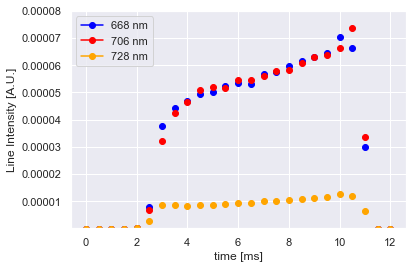

In [11]:
for it in range(len(timeFit)):
    lint668 = integrate.cumtrapz(emis_668_v2[it]*np.exp(-integrate.cumtrapz(tau_668_v2[it],d,initial=0)),xfit)[-1]
    lint706 = integrate.cumtrapz(emis_706_v2[it]*np.exp(-integrate.cumtrapz(tau_706_v2[it],initial=0)),xfit)[-1]
    lint728 = integrate.cumtrapz(emis_728_v2[it]*np.exp(-integrate.cumtrapz(tau_728_v2[it],initial=0)),xfit)[-1]
    if it==0:
        plt.plot(timeFit[it],lint668,color='blue',label='668 nm',marker='o')
        plt.plot(timeFit[it],lint706,color='red',label='706 nm',marker='o')
        plt.plot(timeFit[it],lint728,color='orange',label='728 nm',marker='o')
    else:
        plt.plot(timeFit[it],lint668,color='blue',marker='o')
        plt.plot(timeFit[it],lint706,color='red',marker='o')
        plt.plot(timeFit[it],lint728,color='orange',marker='o')
#plt.yscale('log')
plt.ylim(1e-7,0.8e-4)
plt.ylabel('Line Intensity [A.U.]')
plt.xlabel('time [ms]')
plt.legend()